In [5]:
cd pyDDM

/Users/sam/Documents/GitHub/pyDDM/pyDDM


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from bioviper import msa, pdb
from ddm import DDM, align_structures, helix_bin

from scipy import spatial
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA, SparsePCA, NMF

from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

#so that the pdfs produced are compatible with Adobe Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Arial"

def selector(df, dic):

    '''A little tool for selecting from pandas dataframes by passing a dictionary, e.g.
            selector(df, {"color":"red", "shape":["square", "circle"]})
        
        For advanced usage, you can pass a function and it will return where True, e.g.
            selector(df, ["name": lambda name: "Sam" in name])
            
        You can also use this to select things greater than or less than a value, e.g.
            selector(df, ["enrichment": lambda enr: enr > 1])'''
    
    X = df.copy()

    for key,val in dic.items():
        
        # If you pass a tuple, list or numpy array
        if isinstance(val, (tuple, list, np.ndarray)):
            where = np.any(np.array([X[key]==v for v in val]),axis=0)
            X = X.loc[where]
            
        # If you pass a function
        elif isinstance(val, type(lambda x: x+1)):
            X = X.loc[X[key].apply(val)]
            
        # Otherwise we assume it's a single value
        else:
            X = X.loc[X[key]==val]

    return X

In [24]:
all_leut_fold = pd.read_excel("../data/LeuT fold list of conformations w LAT1 KCC1 2023.xlsx", sheet_name='Sheet1')

proteins = ['LeuT', 'AdiC', 'BetP', 'KCC1', 'LAT1', 'Mhp1', 'MntH', 'SERT', 'SGLT']
nickname_to_uniprot = {'AdiC':'P60063',
                       'MntH':'Q9RTP8',
                       'BetP':'P54582',
                       'SGLT':'P96169',
                       'Mhp1':'D6R8X8',
                       'SERT':'P31645',
                       'LeuT':'O67854',
                       'LAT1':'Q01650',
                       'KCC1':'Q9UP95'}


helix_starts = {
    'AdiC': [13, 27, 43, 84, 125, 146, 157, 192, 208, 221, 275, 324, 352, 360],
    'MntH': [46, 57, 74, 114, 150, 175, 183, 216, 231, 257, 311, 352, 370, 384],
    'SGLT': [54, 67, 82, 125, 161, 187, 199, 249, 269, 280, 349, 394, 422, 434],
    'BetP': [139, 152, 177, 235, 280, 301, 312, 366, 379, 394, 452, 492, 515, 527],
    'Mhp1': [30, 43, 59, 103, 142, 161, 175, 208, 222, 246, 296, 337, 359, 370],
    'SERT': [85, 103, 117, 159, 255, 279, 289, 325, 342, 360, 422, 464, 487, 500],
    'LeuT': [13, 27, 43, 88, 167, 191, 199, 241, 260, 276, 338, 375, 398, 409],
    'KCC1': [121, 137, 148, 196, 250, 272, 283, 419, 434, 448, 504, 555, 576, 584],
    'LAT1': [53, 67, 86, 127, 171, 192, 203, 242, 258, 271, 325, 374, 395, 403]
}

helix_ends = {
    'AdiC': [24, 36, 65, 109, 142, 156, 168, 201, 214, 244, 303, 339, 359, 373],
    'MntH': [54, 70, 100, 146, 165, 182, 194, 227, 236, 286, 340, 365, 383, 396],
    'SGLT': [65, 80, 109, 158, 176, 198, 210, 264, 276, 312, 380, 414, 432, 447],
    'BetP': [147, 168, 210, 266, 292, 306, 324, 373, 387, 426, 479, 506, 524, 538],
    'Mhp1': [41, 55, 86, 134, 159, 174, 186, 220, 232, 278, 329, 349, 369, 382],
    'SERT': [96, 111, 141, 185, 269, 288, 299, 337, 350, 385, 450, 479, 495, 513],
    'LeuT': [21, 38, 69, 121, 184, 198, 209, 254, 267, 306, 370, 396, 407, 423],
    'KCC1': [133, 147, 174, 225, 268, 282, 293, 428, 440, 471, 532, 569, 583, 597],
    'LAT1': [64, 76, 108, 153, 188, 202, 214, 251, 264, 294, 352, 388, 402, 416]
}

conf_order = ["outward open", "outward occluded", "inward occluded", "inward open"]

helix_names = ['1a','1b','2','3','4','5a','5b','6a','6b','7','8','9','10a','10b']
pdb_dir = "/Users/sam/Dropbox (Harvard University)/LeuT-fold structure comparisons/Data and working materials/Structural analyses/PDBs/"

pdbs = np.genfromtxt("../data/pdbs_to_use.csv", delimiter=",", dtype="str")
X = selector(all_leut_fold, {"PDB & chain":pdbs})

transition_list = []

for protein in proteins:
    
    data = []
    
    structures = selector(X, {"Protein": protein})
    confs = structures["Conformation"]
    for nc1, conf1 in enumerate(confs):
        for nc2, conf2 in enumerate(confs[nc1+1:]):
            
            if conf_order.index(conf1) > conf_order.index(conf2):
                conf1, conf2 = conf2, conf1
            
            row1 = selector(structures, {"Conformation":conf1}).iloc[0]
            row2 = selector(structures, {"Conformation":conf2}).iloc[0]
            
            transition_id = '$'+conf1[0].upper() + '_{' + conf1.split(' ')[1][:2] + '}$ → ' + \
                            '$'+conf2[0].upper() + '_{' + conf2.split(' ')[1][:2] + '}$'
            
            transition_list.append([protein, conf1, conf2, transition_id, row1['PDB'], row1['chain'], row2['PDB'], row2['chain']])

#transition_list.append(["MntH", "outward open", "inward open", '$O_{op}$ → $I_{op}$', "6D91", "A", "6D9W", "A"])            
            
all_transitions = pd.DataFrame(transition_list, columns = ("name", "conf1", "conf2", 'transition', 'pdb 1', 'chain 1', 'pdb 2', 'chain 2'))
all_transitions.to_csv("../data/all_transitions.csv")
all_transitions

,name,conf1,conf2,transition,pdb 1,chain 1,pdb 2,chain 2
0,LeuT,outward open,outward occluded,$O_{op}$ → $O_{oc}$,4MMB,A,2A65,A
1,LeuT,outward open,inward occluded,$O_{op}$ → $I_{oc}$,4MMB,A,6XWM,A
2,LeuT,outward open,inward open,$O_{op}$ → $I_{op}$,4MMB,A,3TT3,A
3,LeuT,outward occluded,inward occluded,$O_{oc}$ → $I_{oc}$,2A65,A,6XWM,A
4,LeuT,outward occluded,inward open,$O_{oc}$ → $I_{op}$,2A65,A,3TT3,A
5,LeuT,inward occluded,inward open,$I_{oc}$ → $I_{op}$,6XWM,A,3TT3,A
6,AdiC,outward open,outward occluded,$O_{op}$ → $O_{oc}$,3LRB,A,3L1L,A
7,BetP,outward open,outward occluded,$O_{op}$ → $O_{oc}$,4LLH,A,4AIN,A
8,BetP,outward open,inward open,$O_{op}$ → $I_{op}$,4LLH,A,4C7R,A
9,BetP,outward occluded,inward open,$O_{oc}$ → $I_{op}$,4AIN,A,4C7R,A


In [23]:
label_shift = 5

ddms = {}
ho_ddms = {}
hb_ddms = {}

break_dict = {}
maps = {}

for key, (protein_name, conf1, conf2, comparison, pdb1, chain1, pdb2, chain2) in all_transitions.iterrows():
    
    seq_filename = "../data/uniprot/" + nickname_to_uniprot[protein_name] + ".fa"
    
    # calculate the actual ddm
    ddm, mapping_df = DDM(pdb1, chain1, pdb2, chain2, seq_filename, pdb_dir=pdb_dir)
    ddms[key] = ddm
    
    ho_ddm, mapping_df, breaks = DDM(pdb1, chain1, pdb2, chain2, seq_filename, pdb_dir=pdb_dir, helix_only=True,
                helix_starts=helix_starts[protein_name], helix_ends=helix_ends[protein_name])
    
    ho_ddms[key] = ho_ddm
        
    breaks_0 = np.concatenate([[0], breaks])
    break_dict[key] = breaks_0

    hb_ddm = helix_bin(ho_ddm, breaks_0[:-1], breaks_0[1:])
    hb_ddms[key] = hb_ddm
    
# Save all of these to be loaded later!
np.save("../data/ddms.npy", ddms)
np.save("../data/ho_ddms.npy", ho_ddms)
np.save("../data/hb_ddms.npy", hb_ddms)

## Making plots for the supplemental figures

In [21]:
def ddm_plot(ddm, mapper, ax, protein_name, comparison, xrot=45, yrot=0, cmap="seismic", vmin=-10, vmax=10):

    ax.imshow(ddm,
               cmap=cmap,
               vmax=vmax, 
               vmin=vmin)

    pdb_pos = np.array(mapper["pdb1_pos"]).astype('int')

    _min = np.ceil(np.min(pdb_pos/50))*50
    _max = np.floor(np.max(pdb_pos/50))*50

    ax.set_xticks([np.where(pdb_pos==i)[0][0] for i in np.arange(_min, _max, 50) if i in pdb_pos])
    ax.set_xticklabels([i for i in np.arange(_min, _max, 50).astype('int') if i in pdb_pos], rotation=xrot, fontsize=6)

    ax.set_yticks([np.where(pdb_pos==i)[0][0] for i in np.arange(_min, _max, 50) if i in pdb_pos])
    ax.set_yticklabels([i for i in np.arange(_min, _max, 50).astype('int') if i in pdb_pos], rotation=yrot, fontsize=6)
            
    #ax.set_title(protein_name + ": " + comparison, fontsize=8)

def ho_ddm_plot(ho_ddm, breaks, ax, protein_name, comparison, xrot=90, yrot=0, cmap="seismic", vmin=-10, vmax=10, lw=1):
    
    im = ax.imshow(ho_ddm,
               cmap=cmap,
               vmax=vmax, 
               vmin=vmin)
    
    for p in breaks[:-1]:
        ax.axvline(p, c='k', lw=lw)
        ax.axhline(p, c='k', lw=lw)
        
    label_pos = (breaks[1:] + breaks[:-1])/2
    
    ax.set_xticks(label_pos)
    ax.set_xticklabels(helix_names, fontsize=6, rotation=xrot)
    
    ax.set_yticks(label_pos)
    ax.set_yticklabels(helix_names, fontsize=6)

    #plt.colorbar()
    ax.set_title(protein_name + ": " + comparison, fontsize=8, rotation=yrot)
    
    plt.colorbar(im, ax=ax, shrink=0.7)
    
def hb_ddm_plot(hb_ddm, ax, protein_name, comparison):
    
    im = ax.imshow(hb_ddm, cmap='Greys', vmax=8)
    #ax.colorbar()
    ax.set_xticks(np.arange(len(helix_names)))
    ax.set_xticklabels(helix_names, fontsize=6, rotation=90)
    
    ax.set_yticks(np.arange(len(helix_names)))
    ax.set_yticklabels(helix_names, fontsize=6, rotation=0)
    #ax.set_title(protein_name + ": " + comparison, fontsize=8)
    
    plt.colorbar(im, ax=ax, shrink=0.7)

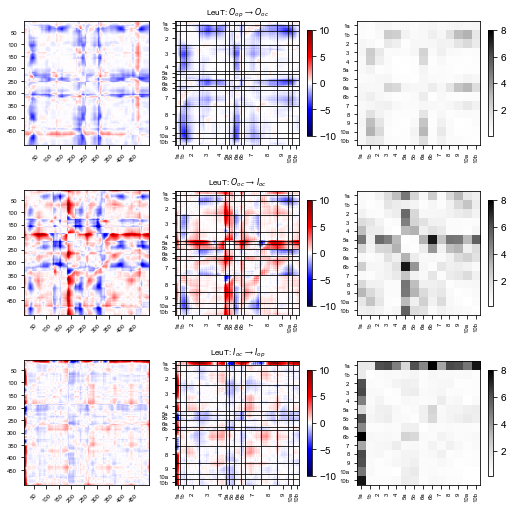

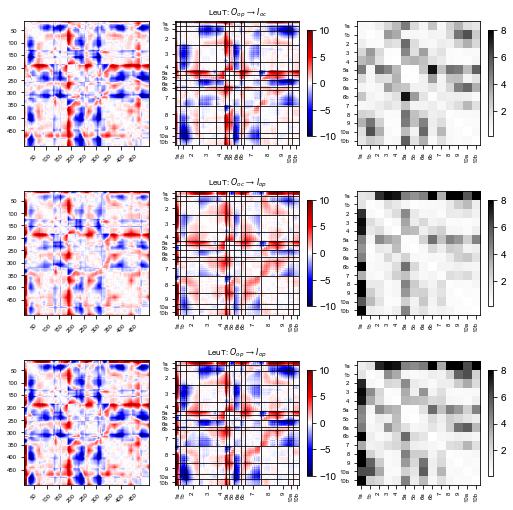

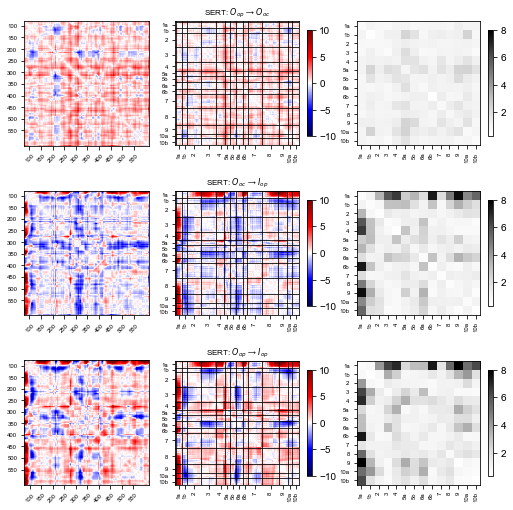

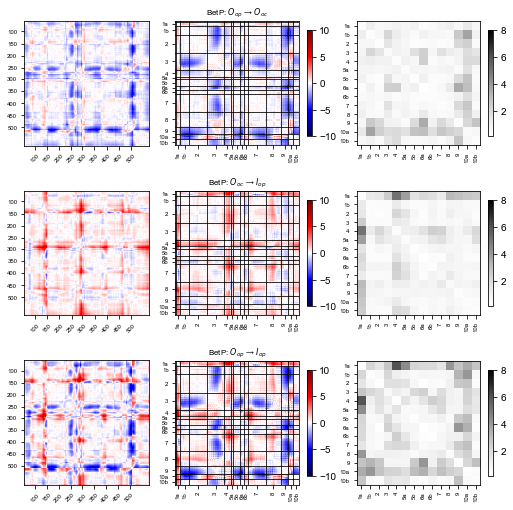

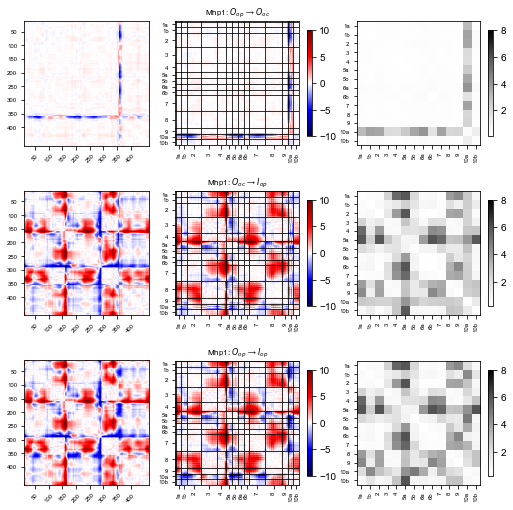

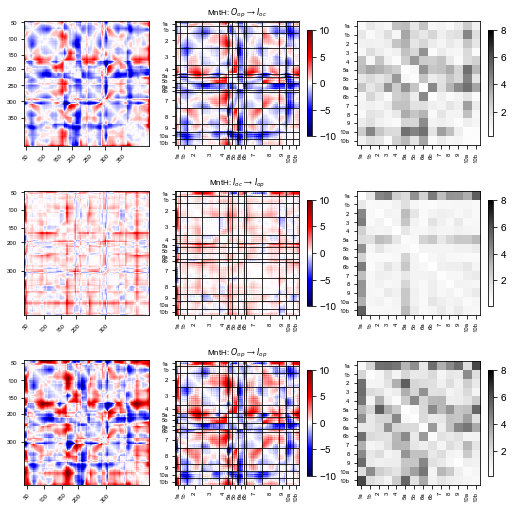

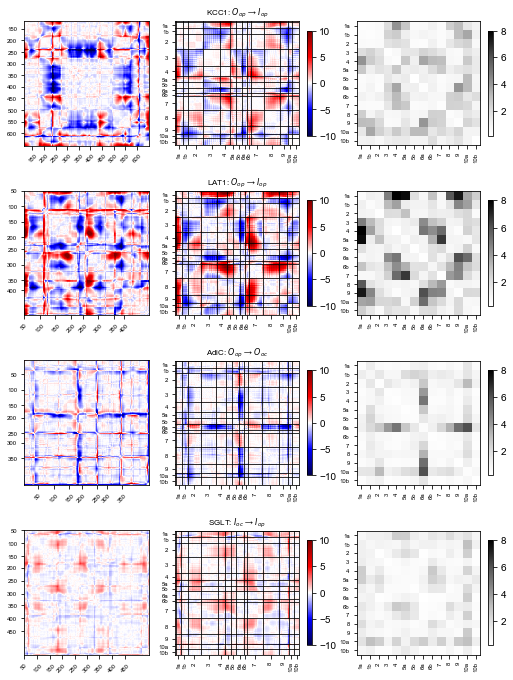

In [22]:
# Making the supplemental figures

# LeuT ONE-STEP
fig, ax = plt.subplots(3, 3, figsize=(7.087, 7.087), gridspec_kw={"width_ratios":(0.3225, 0.4, 0.4)})

for n,i in enumerate([0,3,5]):

    protein_name = str(all_transitions.iloc[i]["name"])
    transition = str(all_transitions.iloc[i]["transition"])
    
    ddm_plot(ddms[i], maps[i], ax[(n,0)], protein_name = protein_name, comparison=transition)
    ho_ddm_plot(ho_ddms[i], break_dict[i], ax[(n,1)], protein_name = protein_name, comparison=transition, lw=0.8)
    hb_ddm_plot(hb_ddms[i], ax[(n,2)], protein_name = protein_name, comparison=transition)
    
fig.tight_layout(pad=0)

#plt.savefig("../Manuscript Figures/Figure S3 DDM plot sup figures/S3_DDMs_1_LeuT_one_step.pdf")
    
# LeuT TWO-STEP
fig, ax = plt.subplots(3, 3, figsize=(7.087, 7.087), gridspec_kw={"width_ratios":(0.3225, 0.4, 0.4)})

for n,i in enumerate([1,4,2]):
    
    protein_name = str(all_transitions.iloc[i]["name"])
    transition = str(all_transitions.iloc[i]["transition"])

    ddm_plot(ddms[i], maps[i], ax[(n,0)], protein_name = protein_name, comparison=transition)
    ho_ddm_plot(ho_ddms[i], break_dict[i], ax[(n,1)], protein_name = protein_name, comparison=transition, lw=0.8)
    hb_ddm_plot(hb_ddms[i], ax[(n,2)], protein_name = protein_name, comparison=transition)

fig.tight_layout(pad=0)

#plt.savefig("../Manuscript Figures/Figure S3 DDM plot sup figures/S3_DDMs_2_LeuT_two_step.pdf")
    
# SERT
fig, ax = plt.subplots(3, 3, figsize=(7.087, 7.087), gridspec_kw={"width_ratios":(0.3225, 0.4, 0.4)})

for n,i in enumerate([18, 20, 19]):
    
    protein_name = str(all_transitions.iloc[i]["name"])
    transition = str(all_transitions.iloc[i]["transition"])

    ddm_plot(ddms[i], maps[i], ax[(n,0)], protein_name = protein_name, comparison=transition)
    ho_ddm_plot(ho_ddms[i], break_dict[i], ax[(n,1)], protein_name = protein_name, comparison=transition, lw=0.8)
    hb_ddm_plot(hb_ddms[i], ax[(n,2)], protein_name = protein_name, comparison=transition)

fig.tight_layout(pad=0)

#plt.savefig("../Manuscript Figures/Figure S3 DDM plot sup figures/S3_DDMs_3_SERT.pdf")
    
# BetP
fig, ax = plt.subplots(3, 3, figsize=(7.087, 7.087), gridspec_kw={"width_ratios":(0.3225, 0.4, 0.4)})

for n,i in enumerate([7, 9, 8]):
    
    protein_name = str(all_transitions.iloc[i]["name"])
    transition = str(all_transitions.iloc[i]["transition"])

    ddm_plot(ddms[i], maps[i], ax[(n,0)], protein_name = protein_name, comparison=transition, )
    ho_ddm_plot(ho_ddms[i], break_dict[i], ax[(n,1)], protein_name = protein_name, comparison=transition, lw=0.8)
    hb_ddm_plot(hb_ddms[i], ax[(n,2)], protein_name = protein_name, comparison=transition)
    
fig.tight_layout(pad=0)

#plt.savefig("../Manuscript Figures/Figure S3 DDM plot sup figures/S3_DDMs_4_BetP.pdf")

# Mhp1
fig, ax = plt.subplots(3, 3, figsize=(7.087, 7.087), gridspec_kw={"width_ratios":(0.3225, 0.4, 0.4)})

for n,i in enumerate([12, 14, 13]):
    
    protein_name = str(all_transitions.iloc[i]["name"])
    transition = str(all_transitions.iloc[i]["transition"])

    ddm_plot(ddms[i], maps[i], ax[(n,0)], protein_name = protein_name, comparison=transition, )
    ho_ddm_plot(ho_ddms[i], break_dict[i], ax[(n,1)], protein_name = protein_name, comparison=transition, lw=0.8)
    hb_ddm_plot(hb_ddms[i], ax[(n,2)], protein_name = protein_name, comparison=transition, )

fig.tight_layout(pad=0)

#plt.savefig("../Manuscript Figures/Figure S3 DDM plot sup figures/S3_DDMs_5_Mhp1.pdf")

# MntH
fig, ax = plt.subplots(3, 3, figsize=(7.087, 7.087), gridspec_kw={"width_ratios":(0.3225, 0.4, 0.4)})

for n,i in enumerate([15, 17, 16]):
    
    protein_name = str(all_transitions.iloc[i]["name"])
    transition = str(all_transitions.iloc[i]["transition"])

    ddm_plot(ddms[i], maps[i], ax[(n,0)], protein_name = protein_name, comparison=transition, )
    ho_ddm_plot(ho_ddms[i], break_dict[i], ax[(n,1)], protein_name = protein_name, comparison=transition, lw=0.8)
    hb_ddm_plot(hb_ddms[i], ax[(n,2)], protein_name = protein_name, comparison=transition, )

fig.tight_layout(pad=0)

#plt.savefig("../Manuscript Figures/Figure S3 DDM plot sup figures/S3_DDMs_6_MntH.pdf")

# Last page 
fig, ax = plt.subplots(4, 3, figsize=(7.087, 9.45), gridspec_kw={"width_ratios":(0.3225, 0.4, 0.4)})

for n,i in enumerate([10, 11, 6, 21]):
    
    protein_name = str(all_transitions.iloc[i]["name"])
    transition = str(all_transitions.iloc[i]["transition"])

    ddm_plot(ddms[i], maps[i], ax[(n,0)], protein_name = protein_name, comparison=transition, )
    ho_ddm_plot(ho_ddms[i], break_dict[i], ax[(n,1)], protein_name = protein_name, comparison=transition, lw=0.8)
    hb_ddm_plot(hb_ddms[i], ax[(n,2)], protein_name = protein_name, comparison=transition)
    
fig.tight_layout(pad=0)

#plt.savefig("../Manuscript Figures/Figure S3 DDM plot sup figures/S3_DDMs_7_KCC1_LAT1_AdiC_SGLT.pdf")